The purpose of this code is to quantify the nuclei, the size and number of synuclein inclusions for each image.

Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from skimage import exposure
from skimage.filters import gaussian, threshold_otsu

from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, binary_dilation, disk
from skimage.segmentation import find_boundaries

from cellpose import models, denoise
from cellpose.utils import fill_holes_and_remove_small_masks

from aicspylibczi import CziFile

model = models.Cellpose(model_type='cyto3')
nuclei_model = models.Cellpose(model_type='nuclei')
model_3d = denoise.CellposeDenoiseModel(model_type="cyto3",
             restore_type="denoise_cyto3", chan2_restore=True)

loading model for chan2: denoise_nuclei


Define Sub Functions

In [2]:
MIN_INCLUSION_SIZE = 10
MAX_INCLUSION_SIZE = 10000
COLOR_SCHEME = 'viridis'
RADIUS = 7

# debug parameters
DISPLAY_INCLUSION_GRAPH = False
VERBOSE = False

In [3]:
def show_image(image, title=None, cmap=COLOR_SCHEME):
    """Display a single image with an optional title and colorbar."""
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def show_images(images, titles=None, cmap=COLOR_SCHEME):
    """Display a grid of images with optional titles and colorbars."""
    n = len(images)
    cols = min(n, 5)
    rows = -(-n // cols)  # ceiling division
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = np.atleast_2d(axes).reshape(rows, cols)

    for i, img in enumerate(images):
        ax = axes[i // cols, i % cols]
        im = ax.imshow(img, cmap=cmap)
        if titles:
            ax.set_title(titles[i])
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    for j in range(i + 1, rows * cols):
        axes[j // cols, j % cols].axis('off')

    plt.tight_layout()
    plt.show()



def normalize_image(image):
    """Normalize image to [0, 1]."""
    min_val, max_val = np.min(image), np.max(image)
    return image if max_val - min_val == 0 else (image - min_val) / (max_val - min_val)

def preprocess_cellpose_image(image):
    """Prepare image for Cellpose: normalize, gamma correct, clip, and blur."""
    image = normalize_image(image)
    image = gaussian(image, sigma=2)
    image = normalize_image(image ** 0.01)  # gamma correction
    clip_threshold = np.percentile(image, 90)
    image = np.clip(image, 0, clip_threshold) / clip_threshold
    image = gaussian(image, sigma=2)
    return normalize_image(gaussian(image, sigma=2))

def increase_contrast(image):
    """Increase the contrast of the image."""
    p2, p98 = np.percentile(image, (2, 98))
    return exposure.rescale_intensity(image, in_range=(p2, p98))


def segment_cells(green_channel):
    """Segment cells in the green channel."""
    # increase contrast
    green_channel = increase_contrast(green_channel)
    # normalize
    green_channel = normalize_image(green_channel)
    mean_intensity = np.mean(green_channel[green_channel > 0.2])
    # print("Mean Intensity: ", mean_intensity)
    green_channel_remove_inclusions = np.where(green_channel < 0.6, green_channel, mean_intensity) # dim down inclusions
    green_channel_remove_inclusions = gaussian(green_channel_remove_inclusions, sigma=5) # blur

    
    # normalize
    green_channel_remove_inclusions = normalize_image(green_channel_remove_inclusions)
    

    # add padding
    padding = 50
    green_channel_remove_inclusions = np.pad(green_channel_remove_inclusions, ((padding, padding), (padding, padding)), mode='constant', constant_values=0)
    # Detect cells in the green channel
    # keep increasing diameter until cells are detected
    diameter = 200

    while diameter < 700:

        masks, flows, styles, diams = model.eval(green_channel_remove_inclusions, diameter=diameter, channels=[0, 0])
        labeled_cells = label(masks)
        # if there are more than 0 cells
        if np.max(labeled_cells) > 0:
            # remove padding
            labeled_cells = labeled_cells[padding:-padding, padding:-padding]
            return labeled_cells
        diameter += 25
    # no cells found, throw an error
    return None


def segment_cells_3D(green_channels, blue_channels=None):
    """Segment 3D cells across z-slices."""
    if blue_channels is None:
        # preprocess each slice separately
        preprocessed_slices = np.stack(
            [preprocess_cellpose_image(green_channels[z]) for z in range(green_channels.shape[0])],
            axis=0
        )
        channel_data = preprocessed_slices
        channels = [0, 0]
    else:
        channel_data = np.stack([green_channels, blue_channels], axis=1)
        channels = [1, 2]

    for diameter in range(200, 700, 25):
        masks, _, _, _ = model.eval(
            channel_data,
            diameter=diameter,
            channels=channels,
            channel_axis=1,
            do_3D=False, # use 2D model on each slice and then stitch
            anisotropy=10.5,
            min_size=10000,
            stitch_threshold=0.5, 
        )

        if np.sum(masks) > 0:
            return [label(masks[i]) for i in range(masks.shape[0])]

    print("No cells found.")
    return np.zeros_like(green_channels)

def calculate_circularity_index(mask):
    """Calculate circularity index of a binary mask."""
    if np.sum(mask) == 0:
        return 0
    area = np.sum(mask)
    perimeter = np.sum(find_boundaries(mask, mode='outer', connectivity=2))
    return (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

def extract_inclusions(green_channel, cell_mask,  display_graph=False):
    """Detect inclusions inside a cell mask using intensity distribution."""

    green_channel = normalize_image(green_channel)
    blurred = gaussian(green_channel, sigma=2)
    masked = blurred * cell_mask
    values = normalize_image(masked[masked > 0])

    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    hist, bins = np.histogram(values, bins='fd')

    if q3 < 0.4 and len(bins) > 20:
        threshold = max(threshold_otsu(green_channel * cell_mask), 0.4) 
    elif q3 >= 0.7:
        threshold = 1
    else:
        threshold = 0.999

    binary = (green_channel * cell_mask) > threshold
    filtered = remove_small_objects(binary, MIN_INCLUSION_SIZE)
    inclusions = filtered ^ remove_small_objects(filtered, MAX_INCLUSION_SIZE)
    inclusions_labeled = label(inclusions)
    # remove inclusions with circularity index < 0.1
    for region in regionprops(inclusions_labeled):
        
        circularity = calculate_circularity_index(inclusions_labeled == region.label)
        if circularity < 0.3:
            inclusions[inclusions_labeled == region.label] = False
        

    if display_graph:
        plt.hist(values, bins='fd')
        for val, _label, color in zip(
            [np.mean(values), np.median(values), q1, q3, threshold],
            ['Mean', 'Median', 'Q1', 'Q3', 'Threshold'],
            ['red', 'green', 'blue', 'purple', 'orange'],
        ):
            plt.axvline(val, color=color, linestyle='--', label=f'{_label}: {val:.2f}')
        plt.legend()
        plt.title("Intensity Histogram")
        plt.show()

        show_image(inclusions, title="Inclusions")

    return inclusions


def generate_inclusion_image(green_channel, labeled_cells):
    """Return binary inclusion image from labeled cells."""
    inclusion_map = np.zeros_like(green_channel)

    for region in regionprops(labeled_cells):
        if region.area < 100:
            continue
        mask = labeled_cells == region.label
        inclusion_map += extract_inclusions(green_channel, mask, display_graph=DISPLAY_INCLUSION_GRAPH)

    return inclusion_map





def segment_nuclei_image(nuclei_image):
    """Segment the nuclei image using Cellpose."""
    masks, flows, styles, diams = model.eval(nuclei_image, diameter=None, channels=[0, 0])
    return masks





In [4]:
def analyze_image(image_path, basename):
    """
    Analyze an image by its individual cells
    Args:
        image_path: Path to the .czi image file.
        basename: Base name for the file, used in the output DataFrame.

    Returns:
        A DataFrame containing details about each image 
        A second DataFrame containing details about each detected cell
    """
    
    # Load the image and squeeze dimensions
    czifile = CziFile(image_path)
    image = np.squeeze(czifile.read_image(S=1)[0])

    image_squeezed = np.squeeze(image)
    show_image(image_squeezed[0], title="Green Channel")
    # Separate the channels
    green_channel = image_squeezed[0, :, :]
    blue_channel = image_squeezed[1, :, :]

    


    labeled_cells = segment_cells(green_channel)
    
    print("Segmented Cells")
    show_image(labeled_cells)


    # Initialize lists to store results
    cell_counter = []
    cell_size = []
    num_inclusions = []
    total_inclusion_areas = []
    average_inclusion_areas = []

    inclusion_areas_list = []
    inclusion_counter = []
    inclusion_counter_cells = []

    # Analyze each detected cell
    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 100:
            continue
        
        cell_counter.append(i)
        cell_size.append(cell.area)
        
        mask = labeled_cells == cell.label
        
        inclusions = extract_inclusions(green_channel, mask, display_graph=False) # extract inclusions from the green channel
        
        inclusions_labeled = label(inclusions)
        
        inclusion_areas = [inclusion.area for inclusion in regionprops(inclusions_labeled)] 
        if len(inclusion_areas) > 0:
            show_image(inclusions)
            print(f"Cell {i}: Number of inclusions: {len(inclusion_areas)}")
            print(f"Cell {i}: Inclusion areas: {inclusion_areas}")
        inclusion_areas = np.array(inclusion_areas)
        total_inclusion_area = np.sum(inclusion_areas)
        average_inclusion_area = np.mean(inclusion_areas)
        
        
        # store results
        total_inclusion_areas.append(total_inclusion_area)
        num_inclusions.append(len(inclusion_areas))
        inclusion_areas_list.append(inclusion_areas)
        inclusion_counter.append(range(len(inclusion_areas)))
        inclusion_counter_cells.append([i] * len(inclusion_areas))
        average_inclusion_areas.append(average_inclusion_area)

    
    # analysis by image
    df1 = pd.DataFrame({
        "File_Name:": [basename],
        "Number_of_Inclusions": [np.sum(num_inclusions)],
    })
    
    # analysis by cell
    df2 = pd.DataFrame({
        "File_Name": [basename] * len(cell_counter),
        "Cell": cell_counter,
        "Num_Inclusions": num_inclusions
    })
    
    # analysis by inclusion
    if len(inclusion_counter) == 0:
        df3 = pd.DataFrame()
    else:
        df3 = pd.DataFrame({
            "File_Name": [basename] * len(np.concatenate(inclusion_counter)),
            "Inclusion": np.concatenate(inclusion_counter),
            "Cell": np.concatenate(inclusion_counter_cells),
            "Inclusion_Area": np.concatenate(inclusion_areas_list)
        })

    
    return df1, df2, df3


In [5]:
def analyze_all_images(image_folder):
    all_data_1 = []
    all_data_2 = []
    all_data_3 = []
    for well_image in os.listdir(image_folder):
        
        if well_image.lower().endswith(".czi"):  # Filter for CZI files
            
            print(well_image)

            well_image_path = os.path.join(image_folder, well_image)
            well_image_base_name = os.path.basename(well_image)[:-4]
            
            df1, df2, df3 = analyze_image(well_image_path, well_image_base_name)
            all_data_1.append(df1)
            all_data_2.append(df2)
            all_data_3.append(df3)
            
            print("-" * 200)

    combined_df_1 = pd.concat(all_data_1, ignore_index=True)
    combined_df_1.to_excel(f"{image_folder[:6]}_analysis_by_image_NEW.xlsx", index=False)

    combined_df_2 = pd.concat(all_data_2, ignore_index=True)
    combined_df_2.to_excel(f"{image_folder[:6]}_analysis_by_cell_NEW.xlsx", index=False)

    combined_df_3 = pd.concat(all_data_3, ignore_index=True)
    combined_df_3.to_excel(f"{image_folder[:6]}_analysis_by_inclusion_NEW.xlsx", index=False)

Define Main Function

In [6]:
folders = ['PFF_SCR_TAX_ADAM/120524_PFF_SCR_TAX_ADAM_800']

1K_PFF_ADAMTS19_01.czi


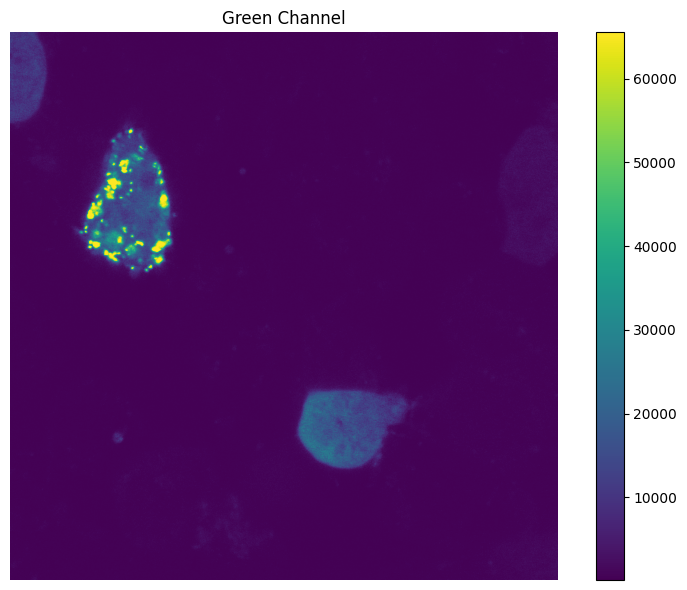

Segmented Cells


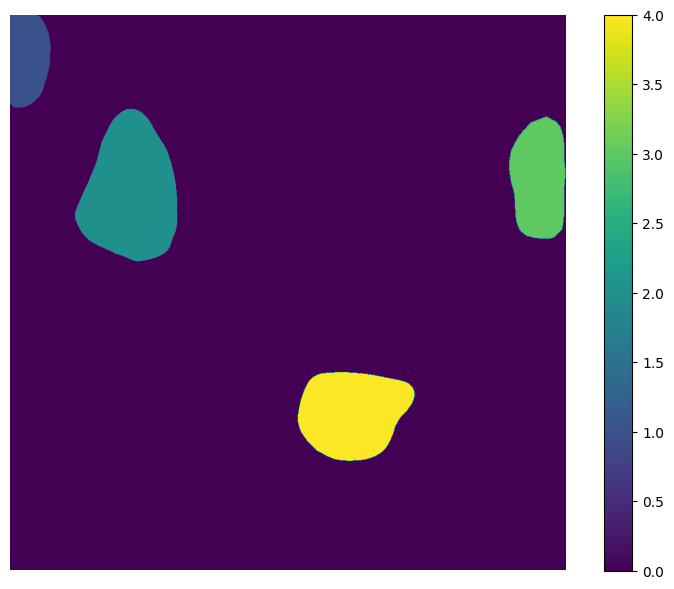

c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


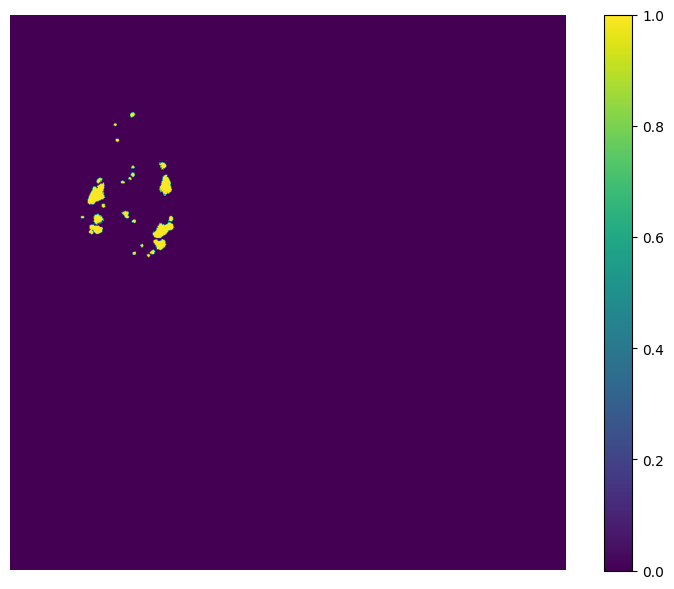

Cell 1: Number of inclusions: 24
Cell 1: Inclusion areas: [np.float64(54.0), np.float64(21.0), np.float64(28.0), np.float64(101.0), np.float64(23.0), np.float64(40.0), np.float64(487.0), np.float64(21.0), np.float64(63.0), np.float64(27.0), np.float64(685.0), np.float64(34.0), np.float64(103.0), np.float64(209.0), np.float64(20.0), np.float64(57.0), np.float64(34.0), np.float64(570.0), np.float64(291.0), np.float64(280.0), np.float64(23.0), np.float64(50.0), np.float64(28.0), np.float64(23.0)]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_PFF_ADAMTS19_02.czi


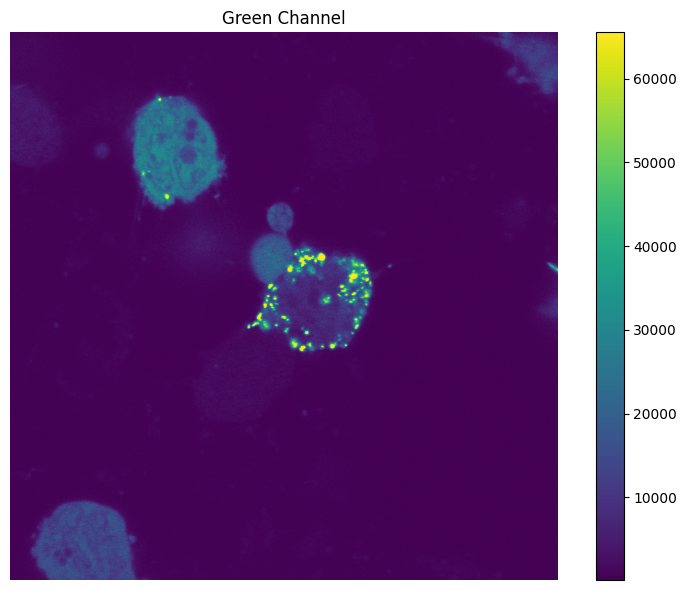

Segmented Cells


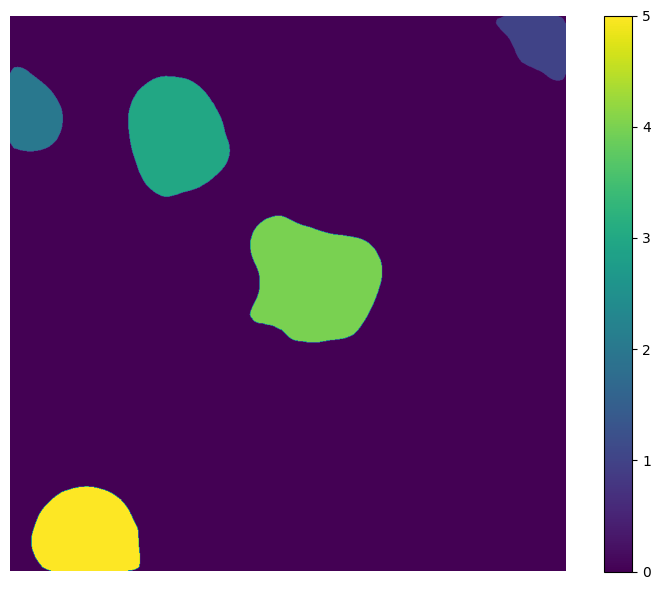

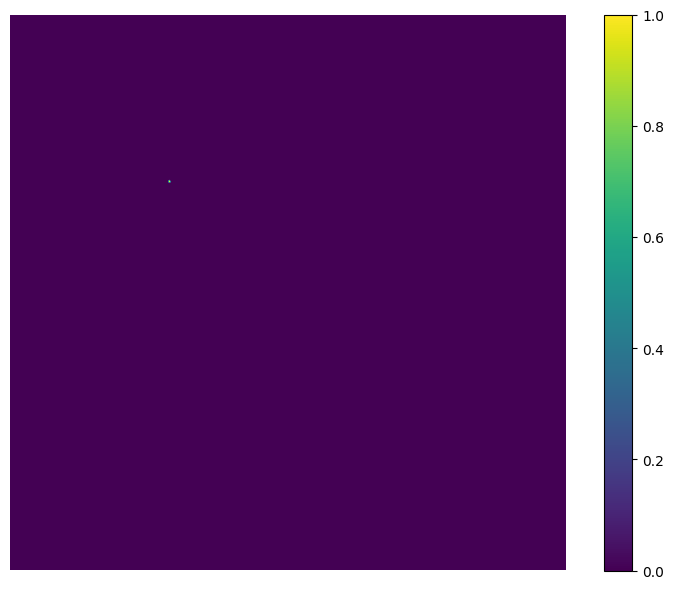

Cell 2: Number of inclusions: 1
Cell 2: Inclusion areas: [np.float64(12.0)]


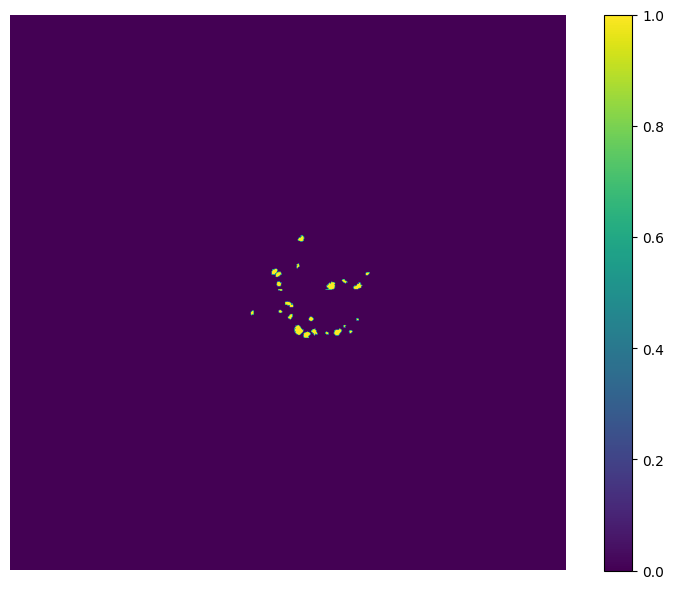

Cell 3: Number of inclusions: 22
Cell 3: Inclusion areas: [np.float64(76.0), np.float64(27.0), np.float64(139.0), np.float64(27.0), np.float64(36.0), np.float64(52.0), np.float64(148.0), np.float64(98.0), np.float64(18.0), np.float64(82.0), np.float64(24.0), np.float64(33.0), np.float64(49.0), np.float64(47.0), np.float64(14.0), np.float64(177.0), np.float64(13.0), np.float64(71.0), np.float64(106.0), np.float64(22.0), np.float64(98.0), np.float64(21.0)]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_PFF_ADAMTS19_03.czi


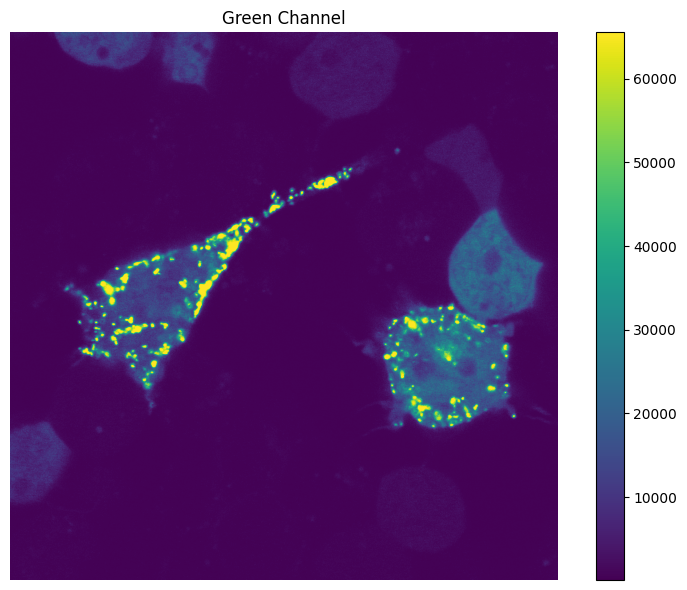

In [ ]:

analyze_all_images(folders[0])